In [1]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# **Preprocess the data**

In [2]:
# Load Dtaset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Encode Labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)



In [3]:
# transformation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(x_train)

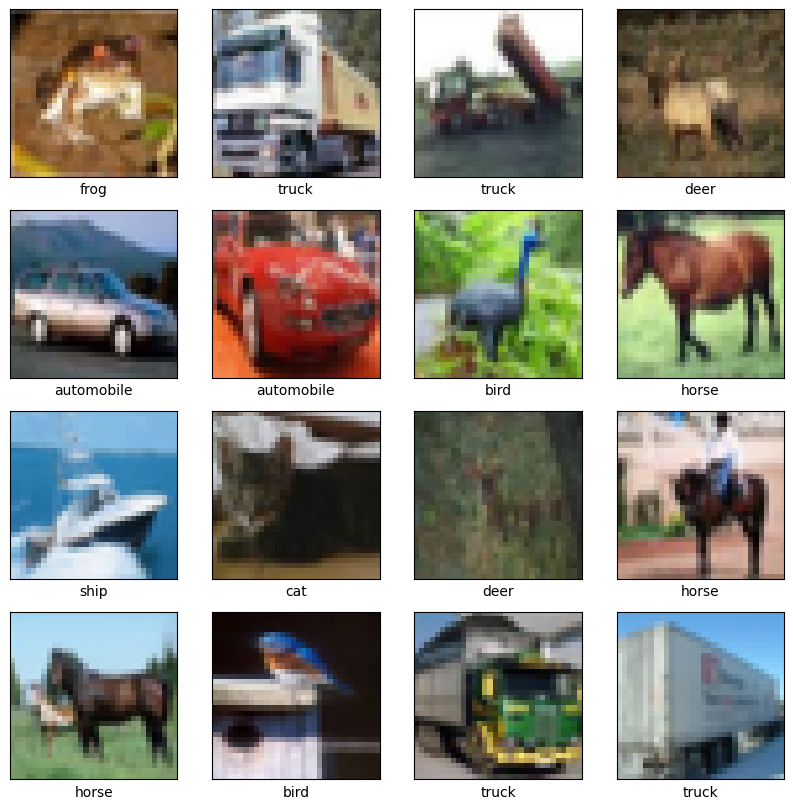

In [4]:
# Visualize so samples
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    plt.xlabel(class_names[y_train[i].argmax()])
plt.show()

#**Creates a convolution block**
**consisting of:**
    
    - Batch Normalization (BN)
    - ReLU Activation
    - Convolution
    Optionally, a bottleneck layer and Dropout can be applied.
    
**Parameters:**
    
    x           : Input tensor.
    nb_channels : Number of filters for the convolution.
    dropout_rate: Dropout rate (if provided).
    bottleneck  : Boolean indicating whether to use a bottleneck layer.
    weight_decay: L2 regularization factor.
    
**Returns:**
    
    The output tensor after applying the convolution block.
    

In [5]:
import tensorflow as tf
from tensorflow.keras import layers

def bn_relu_convolution(x, nb_channels, dropout_rate=None, bottleneck=False, weight_decay=1e-4):

    # If bottleneck is enabled, add a bottleneck layer (1x1 convolution)
    if bottleneck:
        bottleneckWidth = 4  # Factor to multiply the number of filters in the bottleneck layer
        # Apply Batch Normalization
        x = layers.BatchNormalization()(x)
        # Apply ReLU activation
        x = layers.Activation('relu')(x)
        # Apply 1x1 Convolution to reduce the number of channels
        x = layers.Conv2D(nb_channels * bottleneckWidth, (1, 1),
                          kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(x)
        # Apply Dropout if dropout_rate is provided
        if dropout_rate:
            x = layers.Dropout(dropout_rate)(x)

    # Main BN-ReLU-Conv block
    # Apply Batch Normalization
    x = layers.BatchNormalization()(x)
    # Apply ReLU activation
    x = layers.Activation('relu')(x)
    # Apply 3x3 Convolution with 'same' padding to preserve spatial dimensions
    x = layers.Conv2D(nb_channels, (3, 3), padding='same')(x)

    # Apply Dropout if dropout_rate is provided
    if dropout_rate:
        x = layers.Dropout(dropout_rate)(x)

    return x


#**Creates a transition layer between dense blocks**

This layer performs downsampling by reducing the spatial dimensions and compressing the number of channels.
    
**Parameters:**

    x           : Input tensor.
    nb_channels : Number of channels before compression.
    dropout_rate: Dropout rate (if provided).
    compression : Factor by which the number of channels is reduced.
    weight_decay: L2 regularization factor.
    
**Returns:**
The output tensor after applying the transition layer.
    

In [6]:
def bn_relu_transition(x, nb_channels, dropout_rate=None, compression=1.0, weight_decay=1e-4):

    # Apply Batch Normalization
    x = layers.BatchNormalization()(x)
    # Apply ReLU activation
    x = layers.Activation('relu')(x)
    # Apply 1x1 Convolution to reduce the number of channels according to the compression factor
    x = layers.Convolution2D(int(nb_channels * compression), (1, 1), padding='same',
                             kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(x)

    # Apply Dropout if dropout_rate is provided
    if dropout_rate:
        x = layers.Dropout(dropout_rate)(x)

    # Apply Average Pooling with a 2x2 pool size and strides of 2 to downsample spatial dimensions
    x = layers.AveragePooling2D((2, 2), strides=(2, 2))(x)
    return x


#**Creates a Dense Block**
each layer receives feature maps from all preceding layers.
    
**Parameters:**

    x           : Input tensor.
    num_layers  : Number of layers in the dense block.
    nb_channels : Current number of channels.
    growth_rate : Number of filters to add per layer.
    dropout_rate: Dropout rate (if provided).
    bottleneck  : Boolean indicating whether to use a bottleneck layer.
    weight_decay: L2 regularization factor.
    
**Returns:**

    x           : Concatenated output tensor of the dense block.
    nb_channels : Updated number of channels after adding the dense block.
    

In [7]:
def dense_block(x, num_layers, nb_channels, growth_rate, dropout_rate=None, bottleneck=False,
                weight_decay=1e-4):

    for i in range(num_layers):
        # Create new feature maps using the bn_relu_convolution block
        cb = bn_relu_convolution(x, growth_rate, dropout_rate, bottleneck)
        # Update the number of channels by adding the growth rate
        nb_channels += growth_rate
        # Concatenate the new feature maps with the existing ones
        x = layers.concatenate([cb, x])
    return x, nb_channels


#**Builds the DenseNet model**

    
**Parameters:**

    input_shape : Shape of the input data (e.g., image dimensions).
    dense_blocks: Number of dense blocks.
    dense_layers: List specifying the number of layers in each dense block.
    growth_rate : Number of filters to add per layer.
    compression : Factor to compress the number of channels in transition layers.
    bottleneck  : Boolean indicating whether bottleneck layers are used.
    weight_decay: L2 regularization factor.
    dropout_rate: Dropout rate (if provided).
    num_classes : Number of classes for classification.
    
**Returns:**
    A Keras Model instance representing the DenseNet.
    

In [8]:
def DenseNet(input_shape, dense_blocks, dense_layers, growth_rate, compression, bottleneck,
             weight_decay, dropout_rate, num_classes):

    # Print model configuration
    print('Creating DenseNet with Bottleneck = {}'.format(bottleneck))
    print('#############################################')
    print('No. of dense blocks: {}'.format(dense_blocks))
    print('Layers per dense block: {}'.format(dense_layers))
    print('#############################################')

    # Create the input layer
    img_input = layers.Input(shape=input_shape, name='img_input')
    nb_channels = growth_rate  # Initialize channel count with the growth rate

    # Input convolution layer: Apply an initial Conv2D to the input
    x = layers.Conv2D(2 * growth_rate, (3, 3), padding='same', strides=(1, 1), name='input_conv',
                      kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(img_input)

    # Build dense blocks with transition layers in between
    for block in range(dense_blocks - 1):
        # Add a dense block
        x, nb_channels = dense_block(x, dense_layers[block], nb_channels, growth_rate,
                                     dropout_rate, bottleneck, weight_decay)
        # Add a transition layer to downsample and compress the feature maps
        x = bn_relu_transition(x, nb_channels, dropout_rate, compression, weight_decay)
        # Update the channel count after applying compression
        nb_channels = int(nb_channels * compression)

    # Add the last dense block without a transition layer
    x, nb_channels = dense_block(x, dense_layers[-1], nb_channels, growth_rate, dropout_rate, weight_decay)

    # Classification phase:
    # Apply Batch Normalization to stabilize the activations
    x = layers.BatchNormalization(name='prediction_bn')(x)
    # Apply ReLU activation
    x = layers.Activation('relu', name='prediction_relu')(x)
    # Apply Global Average Pooling to convert feature maps into a single vector per sample
    x = layers.GlobalAveragePooling2D(name='prediction_pool')(x)
    # Final Dense layer with softmax activation for classification
    prediction = layers.Dense(num_classes, name='prediction_dense', activation='softmax')(x)

    # Create and return the Keras Model
    return tf.keras.Model(inputs=img_input, outputs=prediction, name='densenet')


#**Create Dense Model**

In [9]:
model = DenseNet(
    input_shape=(32, 32, 3),
    dense_blocks=3,                # Number of dense blocks
    dense_layers=[16]*3,  # Number of layers in each dense block
    growth_rate=12,                # Number of filters to add per layer
    compression=0.5,               # Compression factor in transition layers
    bottleneck=True,               # Use bottleneck layers
    weight_decay=1e-4,             # L2 regularization factor
    dropout_rate=0.3,              # Dropout rate to prevent overfitting
    num_classes=10                 # Number of output classes
)


Creating DenseNet with Bottleneck = True
#############################################
No. of dense blocks: 3
Layers per dense block: [16, 16, 16]
#############################################


In [10]:
model.summary()


Model: "densenet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ img_input (InputLayer)    │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_conv (Conv2D)       │ (None, 32, 32, 24)     │            672 │ img_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 32, 32, 24)     │             96 │ input_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 32, 32, 24)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 48)     │          1,200 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 32, 32, 48)     │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 32, 32, 48)     │            192 │ dropout[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 32, 32, 48)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 12)     │          5,196 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 32, 32, 12)     │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 32, 32, 36)     │              0 │ dropout_1[0][0],       │
│                           │                        │                │ input_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 32, 32, 36)     │            144 │ concatenate[0][0]      │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 32, 32, 36)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 48)     │          1,776 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 32, 32, 48)     │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 32, 32, 48)     │            192 │ dropout_2[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 32, 32, 48)     │              0 │ batch_normalization_3… │
├──────────────────────

 Total params: 785,671 (3.00 MB)

 Trainable params: 761,989 (2.91 MB)

 Non-trainable params: 23,682 (92.51 KB)

**View the model summary**

#**Compile the model**

In [11]:
from tensorflow.keras.optimizers import SGD

# Using SGD with a specific learning rate and momentum
optimizer = SGD(learning_rate=0.01, momentum=0.9)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


#**Train the model**

In [12]:
from tensorflow.keras.callbacks import *

In [13]:
checkpoint = ModelCheckpoint(
    filepath='best_model.weights.h5',  # The path to save the model weights.
    monitor='val_loss',      # The metric to monitor. Here, it's the validation loss.
    verbose=0,               # Verbosity mode; 0 means silent.
    save_best_only=True,     # Only save the model weights when the monitored metric improves.
    save_weights_only=True,  # Only the weights are saved, not the full model.
    mode='min'               # 'min' indicates that a lower monitored value is better.
)


**Reduce LR Plateau**

In [14]:
lr_reduced = ReduceLROnPlateau(
    monitor='val_loss',   # The metric to monitor for improvement.
    mode='min',           # 'min' indicates that the monitored metric should decrease.
    verbose=0,            # Verbosity mode; 0 means silent.
    factor=0.2,           # Factor by which the learning rate will be reduced (new_lr = lr * factor).
    patience=10,          # Number of epochs with no improvement after which the learning rate will be reduced.
    min_lr=0.000001       # The lower bound on the learning rate; the learning rate won't be reduced below this value.
)


In [15]:
from tensorflow.keras.callbacks import EarlyStopping

batch_size = 64
epochs = 100

early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

history = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=[checkpoint,lr_reduced,early_stop]
)


Epoch 1/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 299s 196ms/step - accuracy: 0.2874 - loss: 2.2924 - val_accuracy: 0.2090 - val_loss: 3.3521 - learning_rate: 0.0100
Epoch 2/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 36s 46ms/step - accuracy: 0.4661 - loss: 1.8143 - val_accuracy: 0.2823 - val_loss: 3.3772 - learning_rate: 0.0100
Epoch 3/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 37s 48ms/step - accuracy: 0.5407 - loss: 1.6146 - val_accuracy: 0.3108 - val_loss: 3.5562 - learning_rate: 0.0100
Epoch 4/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 38s 49ms/step - accuracy: 0.5942 - loss: 1.4699 - val_accuracy: 0.4624 - val_loss: 2.0803 - learning_rate: 0.0100
Epoch 5/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 37s 47ms/step - accuracy: 0.6299 - loss: 1.3749 - val_accuracy: 0.4278 - val_loss: 2.3842 - learning_rate: 0.0100
Epoch 6/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 39s 50ms/step - accuracy: 0.6554 - loss: 1.2933 - val_accuracy: 0.6394 - val_loss: 1.4231 - learning_rate: 0.0100
Epoch 7/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 37s 48ms/step - accuracy: 0

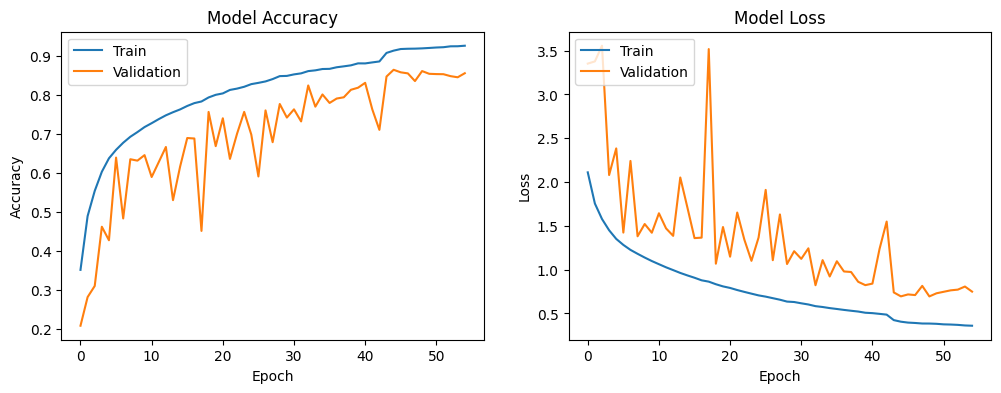

In [16]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


#**Save the entire model to an H5 file**

In [17]:
model.save('densenet_best_model.keras')

#**Evaluate the model on the test set**

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


In [18]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print("Test Loss: {:.4f}".format(test_loss))
print("Test Accuracy: {:.4f}".format(test_accuracy))

Test Loss: 0.6951
Test Accuracy: 0.8642


**Generate predictions for the test set**


In [22]:
# Assuming y_test is one-hot encoded; if not, adjust accordingly.
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)



313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
Accuracy: 0.8642
Precision: 0.8691
Recall: 0.8642
F1 Score: 0.8642


**Calculate metrics:**
- Accuracy
- Precision
- Recall
-F1 score

In [ ]:

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))


**Compute the confusion matrix**

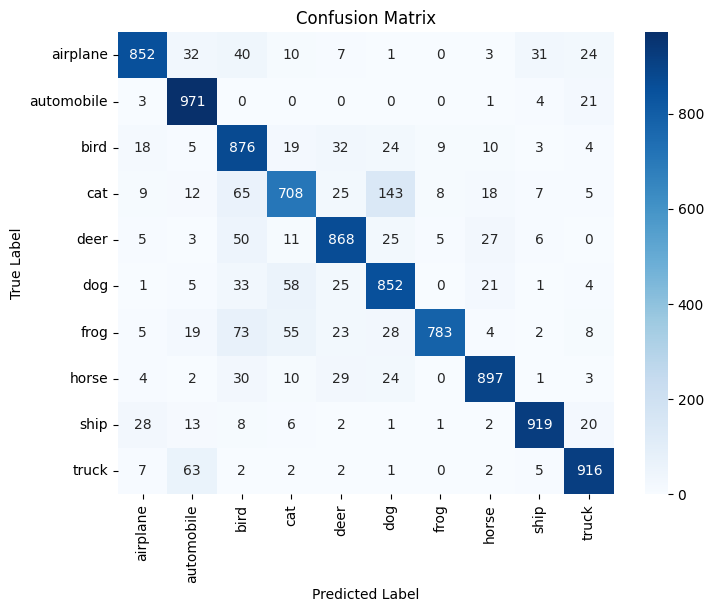

In [26]:
# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()